# Analysis of the Influence of Sea Level Rise and Other Factors on High Tide Flooding Frequency 
### Author: Lauren Dwyre

ESCI 895: Hydrologic Data Analysis

Final Project (Draft)

Date: December 7, 2021

## Introduction
   Rising global temperatures from climate change is predicted to cause major changes in storm intensities, ocean currents, heat wave intensities, and ocean water levels. Sea-level rise (SLR) is a major consequence of climate change from melting glaciers and ice caps, and the volume of the ocean expanding from increasing temperature. It has been found that globally, sea levels have risen eight to nine inches since 1880 and is predicted to rise one foot by the year 2100. SLR in certain areas may be more or less than the global average due to local factors such as erosion, ocean currents, and upstream flood control. For example, the Gulf of Mexico and the Northeast part of the United States are experiencing higher rates of SLR compared to the West Coast United States.
	
   Historically, coastal flooding would only occur during high intensity storms; however, SLR is affecting the intensity and frequency of flooding in coastal communities. The National Oceanic and Atmospheric Administration (NOAA) has determined flood thresholds for locations across the United States where a NOAA Tidal Gauge is present. The three thresholds include minor, moderate, and severe, and they describe the intensity of the flood a location experiences if the water level is at or above this level. The minor flood threshold typically indicates “high tide flooding” where areas will experience flooding from higher high tides and then the flooding will stop once high tide goes to low tide. This minor flooding typically indicates less severe impacts to communities compared to moderate and severe where storm surge is typically present. However, recent research has found certain communities are at risk for SLR alone, indicated by minor flooding. Research indicates that increasing frequency of high tide flooding can lead to infrastructure deterioration as well as affecting important transportation networks (Jacobs, 2018). Understanding how high tide flooding has changed historically, and how it’s predicted to change is important for researchers, engineers, and decision-makers make coastal adaptation plans to assist in protecting community infrastructure and transportation networks. 

   The goal of this study was to determine the high tide flood frequency in Nantucket, MA and how it has changed over the past two decades. Using this period of record as well as NOAA’s SLR prediction for the site, a prediction of how the frequency will change in upcoming decades was performed to determine the impact SLR will have on flood hours per year. In addition to investigating the impacts SLR has on coastal flooding, seasonality and wind speed and direction were explored to determine their influence on minor flooding. With this analysis, community planners and engineers can determine the intensity of impacts Nantucket will face in the near and distant future and explore the potential risks associated with these impacts. Understanding the impacts and risks' intensity can assist decision makers to determine the best adaptation technologies and practices to mitigate the increase in flood frequency.


## Site Description
The Northeastern part of the United States is predicted to have an increase in flood frequency and be more heavily impacted by sea-level rise compared to other areas of the country and globe. The Northeast is also know for the large number of heavily populated coastal communities and important transportation networks that serve as interstate travel as well as emergency escape routes for citizens. Nantucket, MA was considered for this analysis because of its current vulnerability to high tide flooding and its projection for it to increase in the future with its SLR rate. 

Nantucket is a small island (105.3 mi2) about 30 miles off the coast of Cape Cod with an average elevation of 30 feet above sea level. The climate for the island is temperate oceanic climate which is rare for the northeast United States. This means that the winters are milder and the summers are warm, and that there is not a separate dry and wet seasons. Its average high temperature in January is about 39 degrees Fahrenheit and the average temperature in July is about 79 degrees Fahrenheit. Nantucket receives above average rainfall compared to the average of the United States with 45.8 inches annually. 

The island is considered to be a popular summer vacation spot and is known for its characteristic buildings and cobblestone streets. It is also well known for its dune beaches which are constantly changing from storms and tidal currents. However, Nantucket, like many coastal and island communities in the Gulf of Maine, is currently prepararing climate adaptation plans to sustainably mitigate current flooding as well as the predicited increase in flooding in future decades. The Nantucket Conservancy 

[Figure 1](sitemap.png) displays a location map of Nantucket Island with the two different stations that were used for the analysis. The water level data were gathered from a NOAA tide gauge Station 8449130 with latitude and longitude coordinates of blank, blank. This station was established blank, with the most recent installation being in blank. The station’s elevation is blank ft above mean sea level (MSL). The station collects water level data at 6 minute-intervals based on the selected datum. Hourly water level data were used from January 1, 2000 to December 31, 2020 was downloaded in CSV format with the datum set at MSL. The second data set that were used was NOAA’s Local Climatology Station, specifically the hourly windspeed and wind direction data. The second station selected from the NOAA Local Climatology Network is Station WBAN:14756 and latitude and longitude 41.25306°, -70.06083°. The station’s elevation is 45 feet above MSL. The period of record for this station is from January 1, 1948 to present. January 1 to December 31, 2020 was the record downloaded for this analysis in CSV format.


## Methods and Results

### Importing Libraries and Reading in Datafiles
The first thing that was done was import important Python libraries that were going to be used throughout the analysis. These libraries included NumPy, Pandas, Matplotlib, and datetime.

In [2]:
import numpy as np                   # functions for data analysis 
import pandas as pd                  # functions for data frames
from matplotlib import pyplot as plt # functions for plotting
import datetime
import glob

Next, the datafiles that were used for the analysis were downloaded. This included the dataset from 2000 to 2020 for the Nantucket, MA Station (datum was Mean Sea Level (MSL)) and the 2020 dataset for the NOAA Local Climatology Station at Nantucket Airport, MA. These files were downloaded as CSV files and saved into the working directory for the project. Information regarding the minor or nuisance flood thresholds specific to the Massachusetts Coast were gathered from the NOAA Inundation History site where a minor flood threshold for Nantucket is given as about 3.25 feet above MSL. The Mean High High Water (MHHW) datum was also recorded. Sea Level Trend data was also gathered from the NOAA Sea Level Trend Site where a 3.79 mm/year was determined as the relative sea level trend for the Nantucket station.  Once this data were gathered and organized, the constants were defined to be used throughout the code. These constants included the filenames, locations of the stations used, minor flood threshold, MHHW datum, and sea level trend.

In [3]:
path = r'C:\Users\ldwyr\OneDrive\Desktop\ESCI 895\Project\WL_CSV'
filenames = glob.glob(path + "/*.csv")
wind_filename = 'wind.csv'
location = 'Nantucket, MA'
datum = 'Mean Sea Level'
threshold = 3.25 # feet
mhhw = 1.8 # feet
slr = 3.79/304.8 # feet/year

Since the NOAA Water Level Data could only be downloaded for one year at a time, a for loop was created to read in each of the water level files with defining nan values as “NaN”, "-", “9999”, and “-9999” and saving all of the read in files into a list. These nan values were then filled using the "Predicted (ft)" column. The dataframes were saved by concating the datafrma list into a single dataframe (df_wl) . The index was then set to be both the Date and the Time columns. Any values that were determined to be "NaN" in the Verified water level column were filled with the values from the Predicted water level column. Once this was done, all columns except for the verified water level column. 

In [4]:
df_list = []
for filename in filenames:
    df = pd.read_csv(filename, delimiter=",", comment='%', header=0, na_values=(9999, -9999, "NaN",'-'))
    df = df[['Time (LST)', 'Predicted (ft)', 'Verified (ft)', 'Date']]
    df_list.append(df)
df_wl = pd.concat(df_list)
df_wl['Verified (ft)'] = df_wl['Verified (ft)'].fillna(df_wl['Predicted (ft)'])
df_wl['datetime'] = pd.to_datetime(df_wl['Date'].astype(str)+' '+df_wl['Time (LST)'].astype(str))
df_wl.set_index('datetime', inplace = True)
df_wl = df_wl[['Verified (ft)']]

Two new dataframes were created, one for the year 2000 and one for the year 2020. This was done to compare the water level data from the beginning of the analysis record to the end. A figure (Figure 2) showing two timeseries plot, one for each year with the threshold plotted as a horizontal line on both graphs.

In [5]:
start_dates = [datetime.datetime(2000, 1, 1), datetime.datetime(2020, 1, 1)]
end_dates = [datetime.datetime(2000, 12, 31), datetime.datetime(2020, 12, 31)]
df_2000 = df_wl[start_dates[0]:end_dates[0]].copy() 
df_2020 = df_wl[start_dates[1]:end_dates[1]].copy()


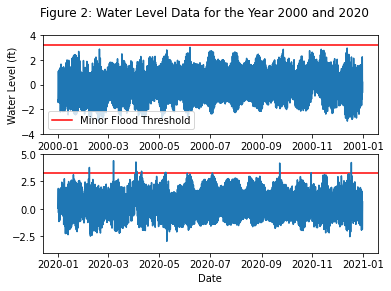

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1)
ax1.plot(df_2000['Verified (ft)'])
ax2.plot(df_2020['Verified (ft)'])
fig.suptitle('Figure 2: Water Level Data for the Year 2000 and 2020')
ax1.set_ylabel('Water Level (ft)')
ax1.set_ylim(bottom = -4, top = 4)
ax2.set_ylim(bottom = -4, top = 5)
ax2.set_xlabel('Date')
for ax in [ax1, ax2]:
    ax.axhline(y=threshold, c="red", zorder=0, label = 'Minor Flood Threshold')
ax1.legend(loc = 'lower left')

Figure 2 above shows how the water high tide water levels in 2000 are about 0.5 feet lower than the high tide water levels in 2020. These plots also show how the range of water levels have also increased since 2000 where there are points in which the low tide water levels were lower 2020 than in 2000.

### Determining Flood Hours
A similar analysis that was performed by the NOAA technical report, Sea Level Rise and Nuisance Flood Frequency Changes around the United States, where the dates, times, and water levels that were at or above the defined minor flooding threshold were located and extracted from df_wl and moved to a new dataframe named df_years.  These times were found by using True/False statements where any water level that was at or above the threshold value defined was determined as True and all other values were determined as False. These True/False values were saved in the df_wl in a column titled "Boolean". The number of hours per year where high tide flooding occurred was calculated by summing the "Boolean" column and grouped by years.

In [7]:
df_wl['Boolean'] = np.where(df_wl['Verified (ft)'] >= threshold, True, False)
df_wl['day'] = df_wl.index.day
df_wl['month'] = df_wl.index.month
df_wl['year'] = df_wl.index.year
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 
         2019, 2020]
df_years = pd.DataFrame(years, columns = ['Year'])
df_years.set_index('Year', inplace = True)
df_years['flood_hours'] = df_wl[['Boolean', 'year']].groupby('year').sum()

#### Distribution of Flood Hours
A figure (Figure 3) was created showing a histogram plotting the frequency of annual flood hours from 2000 to 2020. The purpose was to determine if there was a certain type of distribution that dominated the annual data.

flood_hours    20.285714
dtype: float64


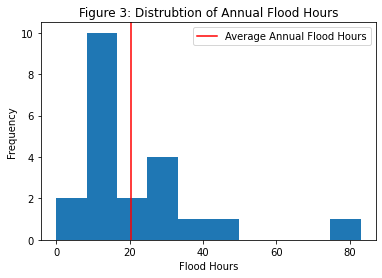

In [8]:
avg = (df_years['flood_hours']).sum()/df_years.count()
print(avg)
fig, ax = plt.subplots()
ax.hist(df_years['flood_hours'])
ax.set_xlabel('Flood Hours')
ax.set_ylabel('Frequency')
plt.axvline(x = 20.285714, color = 'r', label = 'Average Annual Flood Hours')
ax.set_title('Figure 3: Distrubtion of Annual Flood Hours')
ax.legend()

Figure 3 displays the distribution of the annual flood hours with the average annual flood hours plotted as a red vertical line. This histogram does not display a unimodal, normal distribution as the highest peak is before the mean and there is a second peak at around 30 flood hours. It also shows that there was one year that had significantly higher annual flood hours compared to all of the other years in the record. This most likely had a large influence on the average as well as the distribution.

#### Interpolation of the Flood Hours
A linear interpolation of the flood hours over time was performed and plotted against the flood hours measured. The interpolated line was labeled with the equation and the correlation coefficient to determine the extent to which the data follows a linear trend.

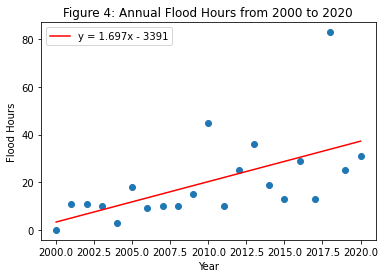

In [9]:
df_years['year_interp'] = years
slope, intercept = np.polyfit(df_years['year_interp'], df_years['flood_hours'], 1)
df_years['interp'] = df_years['year_interp']*slope+intercept
fig, ax = plt.subplots()
ax.scatter(df_years['year_interp'], df_years['flood_hours'])
line = ax.plot(df_years['year_interp'], df_years['interp'], label = 'y = 1.697x - 3391', color = 'r')
ax.set_xlabel('Year')
ax.set_ylabel('Flood Hours')
ax.set_title('Figure 4: Annual Flood Hours from 2000 to 2020')
ax.legend()

Figure 4's linear interpolation line shows that there is a positive trend in amount of flood hours against time. Although there is some variability in the annual data, which is most likely due to certain years having more storms that others, overall there is a general increase in annual flood hours from 2000 to 2020.

### Determining Influences of Flood Hours
#### Seasonality
The NOAA technical report analyzed whether seasonality influenced the amount of high tide flooding that occurred throughout the year. This analysis helps communities plan for flooding during different times of the year. For example, if the fall season has more high tide flooding events occur than in the spring, communities can implement more protection measures during this time of year and less in the spring. The number of flood hours per month was determined similarly to the flood hours per year, except with this analysis, the sum of the True was grouped by the month instead of the year. A bar graph (Figure 5) was created to display the flood hours among the different months.

Text(0, 0.5, 'Flood Hours')

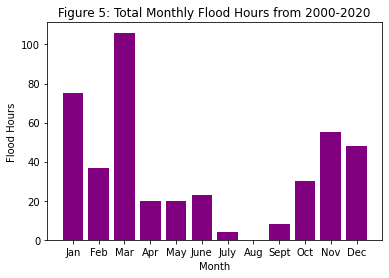

In [10]:
dfmonth = df_wl[['Boolean', 'month']].groupby('month').sum() 
dfmonth['Month Name'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug',
                        'Sept', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots()
ax.bar(dfmonth['Month Name'], dfmonth['Boolean'], color = 'purple')
ax.set_title('Figure 5: Total Monthly Flood Hours from 2000-2020')
ax.set_xlabel('Month')
ax.set_ylabel('Flood Hours')

Figure 5 shows that the highest number of flood hours ocurrs in January and March with the lowest in July and August. To understand the seasonality of the data in more depth, a centroid date was calculated. The centroid in this context represents a weighted averaged time.

In [11]:
# Calculating centroid to describe the seasonality
dfmonth['jdaymid'] = df_wl['day'].groupby(df_wl['month']).median()
centroid = sum(dfmonth['jdaymid']*dfmonth['Boolean'])/sum(dfmonth['Boolean'])
print('Centroid date = ',
      datetime.datetime.strftime(pd.to_datetime(centroid, format="%j"),'%m/%d'))


Centroid date =  01/15


#### Wind
Wind data from NOAA's Local Climatology station in Nantucket was downloaded for the year, 2020. It was read in using the DATE column as the index. The NaN values were defined as '9999', '-9999', 'NaN', and '-' and were filled using the forward fill method because there were not many data gaps. All of the columns were dropped except for the Hourly Wind Direction and the Hourly Wind Speed. The water level data for the year 2020 was analyzed to determine the dates where minor flooding occurred. Histograms of windspeed and direction were created for the flood dates as well as dates that were 2 weeks after each flood event to analyze the difference in windspeed and direction between flood days and non-flood days. The reason two weeks was chosen as the time difference was because there wanted to be enough time to make sure there was enough time after the flooding event but also ensure that they were within the same season since as shown above, seasonality has an effect on flooding.

In [12]:
df_wind = pd.read_csv(wind_filename, delimiter=",", comment='%', header=0, parse_dates=['DATE'], index_col=['DATE'], 
                      usecols = ['DATE','HourlyWindDirection', 'HourlyWindSpeed'], na_values=(9999, -9999, "NaN",'-', 
                                                                                              'VRB', '000'))
df_wind = df_wind.fillna(method = 'ffill')

df_2020['Boolean'] = np.where(df_2020['Verified (ft)'] >= threshold, True, False)

flood_dates1 = [datetime.datetime(2020, 4, 4), datetime.datetime(2020, 6, 3), datetime.datetime(2020, 7, 3), 
               datetime.datetime(2020, 9, 22), datetime.datetime(2020, 12, 17)]
flood_dates2 = [datetime.datetime(2020, 4, 5), datetime.datetime(2020, 6, 4), datetime.datetime(2020, 7, 4), 
               datetime.datetime(2020, 9, 23), datetime.datetime(2020, 12, 18)]

nonflood_dates1 = [datetime.datetime(2020, 4, 18), datetime.datetime(2020, 6, 17), datetime.datetime(2020, 7, 17),
                 datetime.datetime(2020, 10, 6), datetime.datetime(2020, 12, 30)]
nonflood_dates2 = [datetime.datetime(2020, 4, 19), datetime.datetime(2020, 6, 18), datetime.datetime(2020, 7, 18),
                 datetime.datetime(2020, 10, 7), datetime.datetime(2020, 12, 31)]

dfdates = pd.DataFrame(flood_dates1, columns = ['Flood1'])
dfdates['Flood2'] = flood_dates2
dfdates['No Flood1'] = nonflood_dates1
dfdates['No Flood2'] = nonflood_dates2


A figure (Figure 6) of four histograms was created to compare the differences in wind speed and direction between days where a flood occurred and days where there were no floods. 

Text(0.5, 0.98, 'Figure 6: Comparing Windspeed and Direction on Flood Days vs. No Flood days')

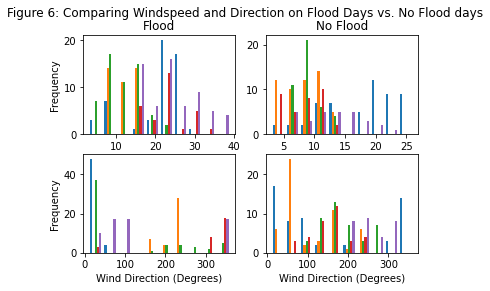

In [13]:
flood_ws = []
flood_wd = []
nonflood_ws = []
nonflood_wd = []

for i, v in dfdates.iterrows():
    ws_flood = df_wind.loc[v[0]:v[1], 'HourlyWindSpeed']
    flood_ws.append(ws_flood)
    wd_flood = df_wind.loc[v[0]:v[1], 'HourlyWindDirection']
    flood_wd.append(wd_flood)
    ws_nonflood = df_wind.loc[v[2]:v[3], 'HourlyWindSpeed']
    nonflood_ws.append(ws_nonflood)
    wd_nonflood = df_wind.loc[v[2]:v[3], 'HourlyWindDirection']
    nonflood_wd.append(wd_nonflood)

fig, ax = plt.subplots(nrows = 2, ncols = 2)    
ax[0, 0].hist(flood_ws)
ax[0, 0].set_title('Flood')
ax[0, 0].set_xlabel('Wind Speed (mph)')
ax[0, 0].set_ylabel('Frequency')
ax[0, 1].hist(nonflood_ws)
ax[0, 1].set_title('No Flood')
ax[0, 1].set_xlabel('Wind Speed (mph)')
ax[1, 0].hist(flood_wd)
ax[1, 0].set_xlabel('Wind Direction (Degrees)')
ax[1, 0].set_ylabel('Frequency')
ax[1, 1].hist(nonflood_wd)
ax[1, 1].set_xlabel('Wind Direction (Degrees)')
fig.suptitle('Figure 6: Comparing Windspeed and Direction on Flood Days vs. No Flood days')

Figure 6 shows that on days where a flood occurs, wind speeds had gone above 30 miles per hour (mph) compared to days where a flood did not occur which only went above 20 mph. Comparing wind directions, days with no floods tended to have a larger variety of wind directions compared to days with floods. According to NOAA, 360 degrees represents true North, 180 is south, west is 270. Using this to interpret the histogram wind directions, on days where flooding occurred, winds were mostly in the Northeast, North and East direction.

### Sea Level Rise Analysis
#### Determining Future Flood Hours using NOAA's Predicted SLR Trend
NOAA has determined SLR trend data for various tidal stations, including the Nantucket station. To determine the number of flood hours in future decades, the df_2000 Verified column was used  since most SLR analyses use the year 2000 as the baseline. New columns were added to the df_2000 dataframe and interpolated water level data using the SLR trend and multiplying this slope by the number of years each decade is from the baseline year, 2000, and was added to the water levels from the df_2000. A similar analysis as before was performed to determine the number of hours for each year that the water level was at or above the threshold. These hours were saved to a new dataframe, df_slr and plotted to show the trend of flood hours over the next century.

Text(0.5, 1.0, 'Figure 7: NOAA SLR Prediction of Flood Hours')

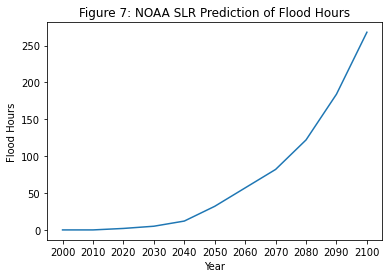

In [14]:
decades = [2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
df_decades = df_2000.copy()

df_decades = df_decades.rename(columns = {'Verified (ft)': '2000'})
df_decades = df_decades[['2000']]
for i, v in enumerate(decades):
    df_decades[str(v)] = df_decades['2000']+slr*(v-2000)
df_flood= df_decades >= threshold
df_flood_hours = df_flood.sum()
fig, ax = plt.subplots()
ax.plot(df_flood_hours)
ax.set_xlabel('Year')
ax.set_ylabel('Flood Hours')
ax.set_title('Figure 7: NOAA SLR Prediction of Flood Hours')

#### Determining Future Flood Hours Using Trendline from 2000-2020
The trendline that was created for the 2000-2020 data was used to determine the number of flood hours per year in future decades to compare to the NOAA SLR trend. 

Text(0.5, 1.0, 'Flood Hour Prediction using Interpolation Equation\nfrom 2000-2020 Record')

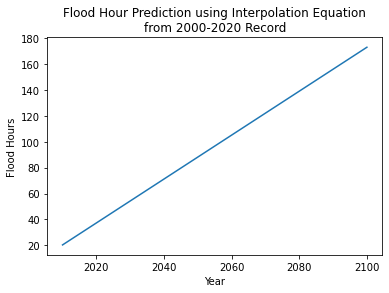

In [15]:
df_interp = pd.DataFrame(decades, columns = ['Years'])
df_interp['flood_interp'] = slope*df_interp['Years']+intercept
fig, ax = plt.subplots()
ax.plot(df_interp['Years'], df_interp['flood_interp'])
ax.set_xlabel('Year')
ax.set_ylabel('Flood Hours')
ax.set_title('Flood Hour Prediction using Interpolation Equation\nfrom 2000-2020 Record')

## Discussion
### Sea Level Rise Impact on High Tide Flooding
Comparing the time series of water levels in 2000 and 2020 in Figure 2, it can be seen that the amount of minor flooding has significantly increased in the twenty years as there are multiple occassions where the the water level goes significantly above the threshold in 2020. Comparing each individual year's flood hours in Figure 4, shows that overall, the amount of flooding has increased annually. There were some years that had very high number of flood hours which included 2010, 2012, and especially 2018. The most likely reason for these high flood hours is due to storm surges and high precipitation events. For example, there was a massive blizzard that occurred in New England in 2018 which most likely contributed to the high tide flooding events during that year.

Looking into future decades, this analysis predicts that flood hours could increase exponentially from the 2000 levels. Using the NOAA SLR predicted rate, by the end of 2100, flood hours is predicted to be over 250 hours annually. This is assuming that the water level will rise at a constant rate and reach a 1.25 foot increase in 2100 compared to 2000. Using the linear trendline that was computed from the flood hours during the record of 2000 to 2020, the flood hours is expected to increase up to 180 hours annually by 2100. This could lead to more days throughout the year where a high tide occurs, as well as longer duration of flooding during high tides.

### Other Impacts on High Tide Flooding
Seasonality of high tide flooding helps planners determine if there are certain times of the year where they need to be more prepared for high tide flooding. When the flood hours of the entire period of record are grouped by months, Figure 5 shows that the most high tide flooding occurs in November through March, with the highest in March. The plot shows that the least amount of high tide flooding occurs in the summer months.

The impacts of wind speed and direction on coastal flooding have recently started to be researched. Figure 6 displays a brief investigation on this relationship. The plots indicates that there are differences between wind speed and direction in days where a flood occurs and days where there is no flooding. Although wind the frequency of wind speeds on flooding days occurred to similar wind speeds on days with no floods, there were multiple events where the wind speeds increased to over 30 mph. In all five non-flooding days that were analyzed, there were no occurrences where the windspeed went above 25 mph. The wind direction of days with no flooding has greater variety compared to the wind direction of flooding days. One days with flooding, the highest frequency wind directions occurred in the Northeast and East directions, with one event have winds mostly in the west direction.


The following sections will become more developed for the final report
### Limitations
This analysis did not separate minor flooding from major and extreme flooding which means that there are most likely events in the data that do not fall within the minor flooding range and go into higher flooding events. 

This analysis only investigated a constant SLR. If countries do not start climate mitigation and reducing greenhouse gas emissions, this SLR could accelerate. Similarly, if countries reduce their emissions and improve mitigation, there is still expected to be SLR through the end of the century, but could be less severe.

Wind analysis: no flooding days were picked at 2 weeks after the day that a flood had occurred. This allows only for a rough estimation of what occurs on flooding days and non-flooding days. The non-flooding days might not be representative of an average non-flooding day and there could be other affecting the wind and the water levels on those days as well as flooding days.

### Future Research
1. Analyze minor, moderate, and extreme flooding how the intensity of flooding impacts the community compared to duration of flooding events
2. Look into different scenarios of SLR and how that would affect annual flood hours
3. Look into why seasonality occurs for high tide flooding
4. More in-depth wind analysis
5. Compare this location to another location in the U.S.

## Conclusion
Frequency and duration of flooding events have increased in the last 20 years; SLR will accelerate this increase in frequency in future decades

Climate mitigation is necessary to help reduce the severity of SLR that areas will experience. 

Based on this analysis, Nantucket community decision makers should plan for 50-80 annual flood hours by 2050 and between 180 and over 250 by 2100.

Nantucket community decision makers should plan to have most of their flooding occur from November through March.

Days with higher winds and winds in the Northeast or East direction could indicate a more likely chance for high tide flooding.

## Sources
Will be APA format for the final report

https://tidesandcurrents.noaa.gov/publications/techrpt86_PaP_of_HTFlooding.pdf

https://www.climate.gov/news-features/understanding-climate/climate-change-global-sea-level

Jacobs, J. M., Cattaneo, L. R., Sweet, W., & Mansfield, T. (2018). Recent and Future Outlooks for Nuisance Flooding Impacts on Roadways on the U.S. East Coast. Transportation Research Record: Journal of the Transportation Research Board, 2672(2), 1-10. https://doi.org/10.1177/0361198118756366 
